# Best Practices - PyTorch VGG16 on CIFAR100


## Optimizing VGG16 with NetsPresso Model Compressor
By following this notebook, the user can accelerate (x2.91) and compress (x2.97) the VGG16 with minute performance degradation (-2.11) by using NetsPresso Model Compressor.  

This notebook contains the following 3 parts:

  1. [Model Compression with NetsPresso Model Compressor](#compression)
  2. [Fine-Tuning the Compressed Model](#fine-tuning)
  3. [Performance Comparision](#comparision)
  
For more details about NetsPresso Model Compressor, please visit [Docs](https://docs.netspresso.ai/docs/technology-support-1) and [Netspresso.ai](https://www.netspresso.ai/model-compressor).


<p align="center">
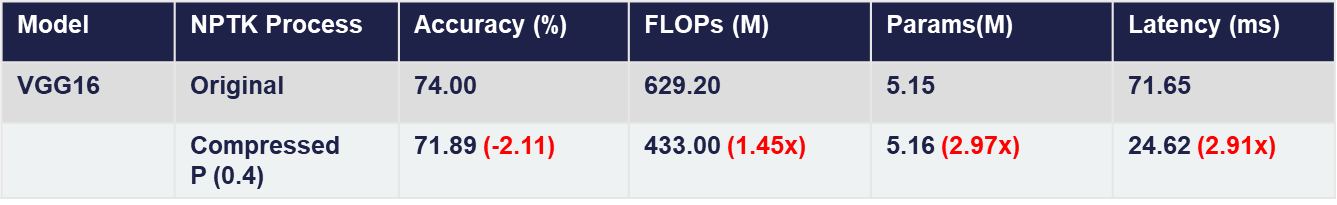
</p>
<figcaption align='center'>
Fig. 1 Compression result of the VGG16. The model's latency is measured using a Raspberry Pi 4B (1.5GHz ARM Cortex).
</figcaption>


<a name="compression"></a>
# 1. Model Compression with NetsPresso Model Compressor


Before starting a best practice, please install the following packages:

In [ ]:
! pip install "torch>=1.10.0"
! pip install "torchvision >=0.12.0"
! pip install torchsummary
! pip install onnx
! pip install onnxruntime
! pip install tqdm
! pip install thop

### Loading the pre-trained VGG16 on CIFAR100
The model is from [here](https://github.com/chenyaofo/pytorch-cifar-models).


In [ ]:
import torch
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg16_bn", pretrained=True)

Determining device to use

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
    print("Using GPU.")
else:
    device = 'cpu'
    print("Using CPU.")

model = model.to(device)

### **VGG16 compression using NetsPresso Model Compressor**

__Compression Guide__
1. Sign up  NetsPresso Model Compressor ([link](https://compression.netspresso.ai/#/login)).
2. Upload the downloaded VGG16. The model should be converted into the ONNX format. Please check the below [code block](#conversion) to convert the model.
3. To compress the model and reproduce the best practice result, please select the following compression procedures one by one as depicted here:
    * `L2 Norm Pruning` &rarr; `Recommendation(SLAMP) pruning ratio: 0.6` & `Policy: Average`
4. Press `Compress` button, and get the compressed model. The compression result will be shown as follow.
---
* If it is hard to follow, please refer to the following user-guide video ([link](https://youtu.be/Qy-yaW0vL4k)).

<p align="center">
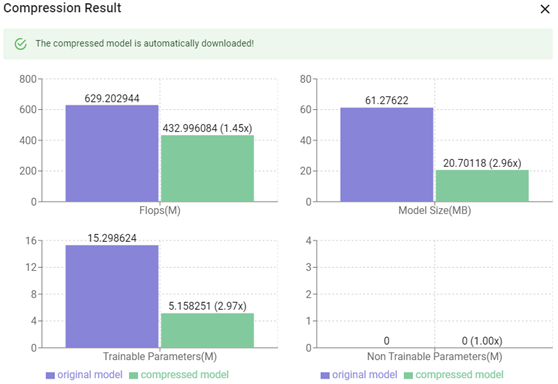


<figcaption align='center'>
Fig 2. The result of the compression on VGG16. Pruning method: L2 Norm Pruning
<figcaption>


<a name="conversion"></a>
Conversion into the ONNX format.

In [ ]:
dummy_input = torch.ones((1,3,32,32)).to(device)
torch.onnx.export(model,dummy_input,"VGG16.onnx",verbose=False,opset_version=14)

<a name="fine-tuning"></a>
# 2. Fine-tuning the Compressed Model.
Structured pruning may induce the performance degradation, which requires additional fine-tuning process.  
Therefore, the fine-tuning process is necessary to compensate the performance after each compression process.  
Here, `Structured Pruning` &rarr; `Fine-tuning`

---
Loading the dataset and the compressed model

In [ ]:
from torchvision import datasets, transforms
# data will be downloaded in data_directory.
data_directory = './data'
batchsize=256

normalize = transforms.Normalize(mean=[0.507, 0.4865, 0.4409],
                                    std=[0.2673, 0.2564, 0.2761])

train_dataset = datasets.CIFAR100(root=data_directory,
                                    train=True,
                                    transform=transforms.Compose([
                                                                  transforms.RandomCrop(32, padding=4),
                                                                  transforms.RandomHorizontalFlip(),
                                                                  transforms.ToTensor(),
                                                                  normalize]),
                                    download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batchsize,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

test_dataset = datasets.CIFAR100(root=data_directory,
                                    train=False,
                                    transform=transforms.Compose([
                                                                  transforms.ToTensor(),
                                                                  normalize]),
                                    download=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batchsize,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)


compressed_model = torch.load("VGG16_compressed_model.pt").to(device)

### Fine-tuning the compressed model

Setting the hyperparameters 

In [ ]:
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR

lr = 0.001
epochs = 100
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(compressed_model.parameters(), lr=lr,
                                momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=200, eta_min=0, verbose=False)

print("All parameters and hyperparameters are set.")

Fine-tuning the compressed model

In [ ]:
import tqdm
# training code
def train(model,criterion, optimizer, scheduler,loader,epoch):
    global device
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    scheduler.step()
    return loss
    
# validation code
def validate(model,loader):
    global device
    model.eval()
    correct = 0.
    total = 0.
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            pred = model(images)

        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    val_acc = (correct / total)*100
    model.train()
    return val_acc

# fine-tune
print("Fine-tuning start...")
best_val = 0
for epoch in range(1,epochs+1):
    
    train(compressed_model,criterion,optimizer,scheduler,train_loader,epoch)
    
    val_acc = validate(compressed_model,test_loader)
    best_val = max(val_acc,best_val)
    
    print(f"epoch[{epoch}/{epochs}] val_acc:{val_acc}")
    
print(f"Fine-tuning is done. Best Accuracy is {best_val}.")

<a name="comparision"></a>
# 3. Performance Comparison

In this section, we visualize and verify the effectiveness of the NetsPresso Model Compressor on VGG16.

* [Visualizing the optimization process](#visualize)
* [Accuracy](#acc)
* [FLOPs and parameters](#flopsParams)
* [Latency](#latency)
* [Architecture of the compressed model](#layerShape)

<a name='visualize'></a>

### Visualizing the optimization process on VGG16
Fig.3 visualizes part of the original and pruned VGG16. Here, we applied [L2 Norm Pruning](https://docs.netspresso.ai/docs/pruning#structured-pruning) to optimize the model.
<p align="center">
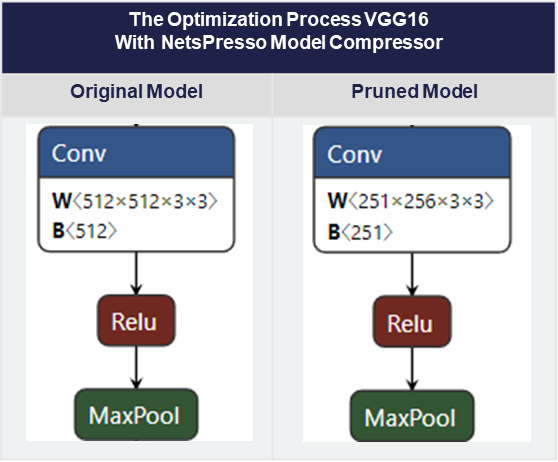

</p>
<figcaption align='center'>
Fig. 3 The optimization process for convolutional neural networks in VGG16 with NetsPresso Model Compressor

</figcaption>

<a name="acc"></a>
### Accuracy comparision

In [ ]:
original_model_accuracy = validate(model,test_loader)
compressed_model_accuracy = validate(compressed_model,test_loader)    

print("--- Original model ==> Compressed model ---")
print(f"Accuracy: {round(original_model_accuracy,3)}% ==> {round(compressed_model_accuracy,3)}%")


<a name="flopsParams"></a>
### FLOPs & Parameters comparision

In [ ]:
from thop import profile

dummy_input = torch.ones((1,3,32,32)).to(device)

model = model.to(device)
compressed_model = compressed_model.to(device)

original_macs, original_params = profile(model, inputs=(dummy_input, ))
compressed_macs, compressed_params = profile(compressed_model, inputs=(dummy_input, ))

print("\n--- Original model ==> Compressed model ---")
print(f"FLOPs: {original_macs*2} ==> {compressed_macs*2} (x{round(original_macs/compressed_macs,3)})")
print(f"Params: {original_params} ==> {compressed_params} (x{round(original_params/compressed_params,3)})")

<a name="latency"></a>
### Latency comparision

In [ ]:
import onnx
def onnxExport(model, model_name, device = torch.device('cpu')):
    model = model.to(device.type)
    dummy_input = torch.ones((1,3,32,32)).to(device.type)
    torch.onnx.export(model,dummy_input,model_name,verbose=False)

onnxExport(compressed_model, 'VGG16_compressed_model.onnx')

In [ ]:
import onnxruntime
import numpy as np

def inference_time(model_path,run_times):
    device = torch.device('cpu')
    img_size = 32
    so = onnxruntime.SessionOptions()
    so.execution_mode = onnxruntime.ExecutionMode.ORT_SEQUENTIAL
    so.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_EXTENDED
    exproviders = [ 'CPUExecutionProvider']
    ort_session = onnxruntime.InferenceSession(model_path, so, providers=exproviders)

    input_names = ort_session.get_inputs()[0].name
    output_names = ort_session.get_outputs()[0].name
    # warm up
    dummy_input = np.random.rand(1,3,32,32).astype(np.float32)
    for _ in range(10):
        #IOBinding
        data = onnxruntime.OrtValue.ortvalue_from_numpy(dummy_input, device.type, 0)
        io_binding = ort_session.io_binding()
        io_binding.bind_input(input_names, device.type, 0, np.float32, [1, 3, img_size, img_size], data.data_ptr())
        io_binding.bind_output(output_names, device.type)

        torch.cuda.synchronize()
        with torch.no_grad():
            ort_session.run_with_iobinding(io_binding)
        torch.cuda.synchronize()

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    latency = []
    for _ in range(run_times):
        dummy_input = np.random.rand(1,3,32,32).astype(np.float32)
        #IOBinding
        data = onnxruntime.OrtValue.ortvalue_from_numpy(dummy_input, device.type, 0)
        io_binding.bind_input(input_names, device.type, 0, np.float32, [1, 3, img_size, img_size], data.data_ptr())
        io_binding.bind_output(output_names, device.type)

        torch.cuda.synchronize()
        start.record() 
        with torch.no_grad():
            ort_session.run_with_iobinding(io_binding)
        end.record()
        torch.cuda.synchronize()
        time_elapsed = start.elapsed_time(end)
        latency.append(time_elapsed)
    return sum(latency)/len(latency)


original_latency = inference_time('VVGG16.onnx',run_times=100)
compressed_latency = inference_time('VGG16_compressed_model.onnx',run_times=100)

print("Original Model ==> Compressed Model")
print(f"Latency: {round(original_latency,3)}ms ==> {round(compressed_latency,3)}ms (x{round(original_latency/compressed_latency,3)})")

<a name="layerShape"></a>

### Architecture of the compressed model

In [ ]:
from torchsummary import summary
summary(compressed_model.to(device),(3,32,32),device=device)